# Encoding models: Poisson General Linear Model (GLM)

In this notebook, we will use a Poisson GLM to learn an encoding transformation
from stimulus to neural activity. In particular, we will be looking at recordings
from retinal ganglion cells in response to binary temporal white noise.

The data we will be using is from [Uzzell & Chichilnisky, 2004](http://jn.physiology.org/content/92/2/780.long); see `README.txt` file in the `/data_RGCs` directory for details).
The dataset can be downloaded [here](https://pillowlab.princeton.edu/data/data_RGCs.zip) (FYI you probably will need to work on this notebook locally to be able to access the downloaded data).

The dataset is provided for tutorial purposes only, and should not be
distributed or used for publication without express permission from EJ
Chichilnisky (ej@stanford.edu).

This notebook was last updated on August 13, 2025 by Jesse Kaminsky. Previously it was made on July 27, 2023 by Iman Wahle and Yousuf El-Jayyousi,
adapted from a set of [notebooks](https://github.com/pillowlab/GLMspiketraintutorial_python) developed by Jesse Kaminsky and JW Pillow. I encourage you to check them out to learn more details and implement more complicated GLMs.

## 1. Load and visualize data

Our dataset includes three pieces of information:

- `stim` : the stimulus value at each frame
- `stim_times` : the time in seconds at each frame (~120 Hz)
- `spike_times` : a list of spike times in seconds for 1 neuron

Before beginning any analyses, let's load the data and make sure it matches
our expectations. In particular:

1. check the data shapes
2. visualize the magnitude of the stimulus over the course of the first 1s of
   the trial (i.e. with `plt.plot`)
3. visualize neuron spike times over the course of the first
   1s of the trial (i.e. with `plt.stem`)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.linalg import norm, hankel
import statsmodels.api as sm
from scipy.optimize import minimize
import seaborn as sns

sns.set_context("notebook")

In [2]:
# load data
datadir = "data_RGCs/"
stim = np.squeeze(loadmat(f"{datadir}Stim.mat")["Stim"])
stim_times = np.squeeze(loadmat(f"{datadir}stimtimes.mat")["stimtimes"])
spike_times = [
    np.squeeze(x) for x in np.squeeze(loadmat(f"{datadir}SpTimes.mat")["SpTimes"])
][2]
dt_stim = stim_times[1] - stim_times[0]
nframes_to_plot = 120

In [3]:
# 1. check the data shapes
print("stim shape: ", stim.shape)
print("stim_times shape: ", stim_times.shape)
print("spike_times shape: ", spike_times.shape)
print("dt: ", dt_stim)

stim shape:  (144051,)
stim_times shape:  (144051,)
spike_times shape:  (49954,)
dt:  0.008340605


Text(0.5, 1.0, 'stim')

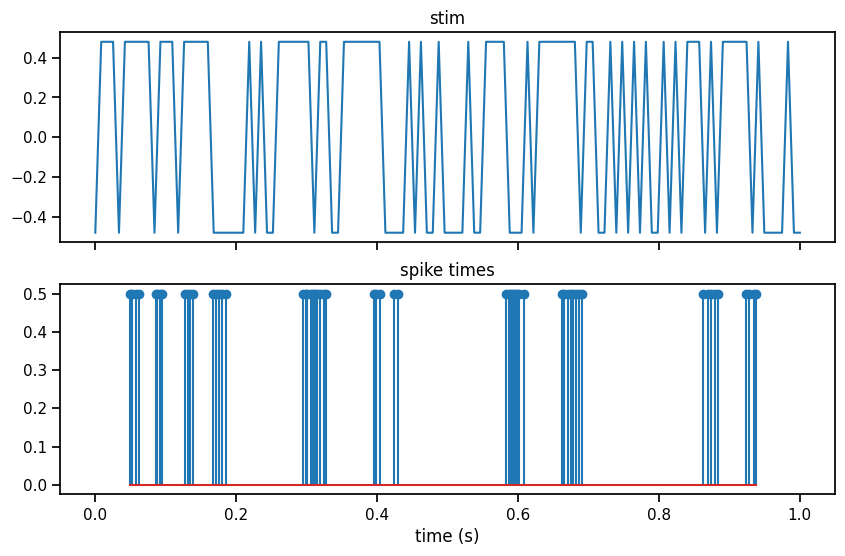

In [4]:
# 2. visualize the magnitude of the stimulus over the course of the first 1s of
#    the trial (i.e. with `plt.plot`)

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(np.linspace(0, 1, 120), stim[:120])

# # 3. visualize neuron 2's (zero-indexed) spike times over the course of the
# #    first 1s of the trial (i.e. with `plt.stem`)
first_second_spikes = spike_times[spike_times < 1]
heights = np.ones_like(first_second_spikes) * 0.5
ax[1].stem(first_second_spikes, heights)
ax[1].set_xlabel('time (s)')
ax[1].set_title('spike times')
ax[0].set_title('stim')





# # get the spike times that fall within the first 1s
# spike_times_1s = ### INSERT CODE HERE

# # plot a dash every time there is a spike
# ### INSERT CODE HERE


## 2. Format data for analysis

In order to map stimulus to neuron responses, we need to compute the number
of spikes that occur during each frame of the stimulus. To do this, find
the time window associated with each stimulus frame and add up the number of
spikes that occur within that time window for each neuron.

One way to do this is to compute the time at the center of each time window
and pass this along with the spike times to `np.histogram`.

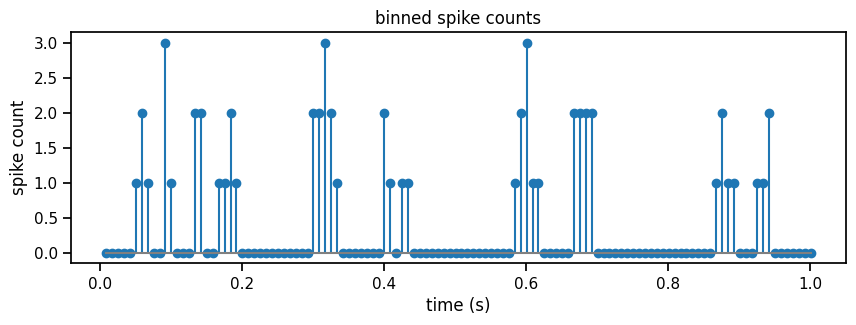

In [5]:
# compute spike counts per time bin
### INSERT CODE HERE
spike_counts, _ = np.histogram(spike_times, bins=np.arange(0, max(stim_times) + dt_stim, dt_stim))

# plot the spike counts over the first 1s of the trial
plt.figure(figsize=(10, 3))
plt.stem(stim_times[:nframes_to_plot], spike_counts[:nframes_to_plot], basefmt="gray")
plt.title("binned spike counts")
plt.ylabel("spike count")
plt.xlabel("time (s)")
plt.show()

Next, we need to construct a design matrix, or a matrix that includes all
regressors we want to include in our model. In our case, stimuli from previous
time points may be important to present spiking activity, so we will include
time-lagged stimuli as individual regressors.

Construct a design matrix with 25 time lags, each shifted over by 1 frame.
This should result in an n_samples x 25 matrix. Pad early samples with zeros
if the lagged frames extend beyond the samples we have.

This can either be constructed using a for loop, or with `scipy.linalg.hankel`.

In [6]:
from numpy.lib.stride_tricks import sliding_window_view

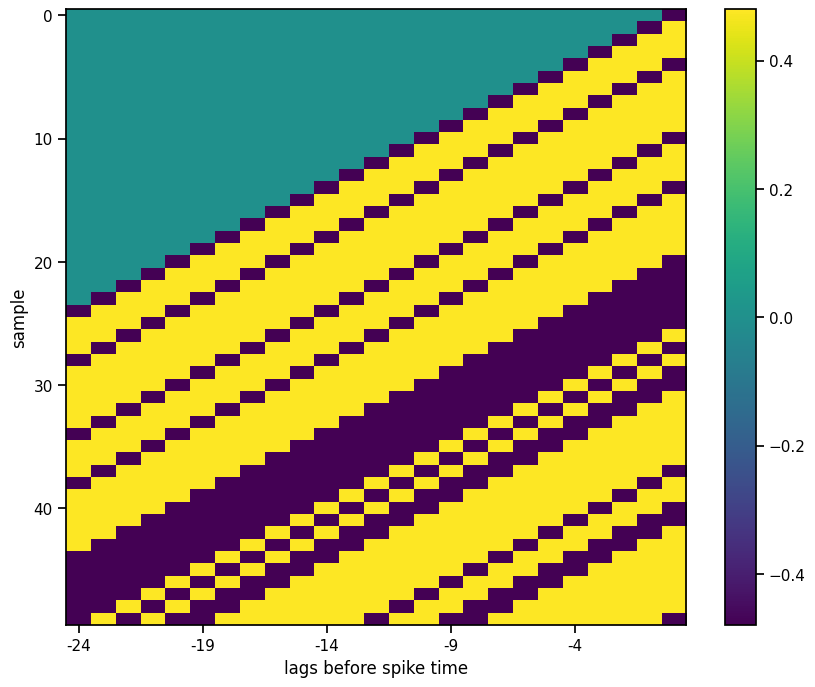

In [7]:

nlags = 25
# Create design matrix containing time-lagged stimuli. It should be of dimension (n_samples X 25)
padded_stim = np.hstack([np.zeros(24), stim])
hankel(padded_stim, nlags)
### INSERT CODE HERE
design_mat = sliding_window_view(np.hstack([np.zeros(24), stim]), 25)

# Let's visualize a small part of the design matrix just to see it
plt.figure(figsize=[10, 8])
plt.imshow(design_mat[:50], aspect="auto", interpolation="nearest")
plt.xticks(np.arange(nlags)[::5], np.arange(nlags)[::5] - nlags + 1)
plt.xlabel("lags before spike time")
plt.ylabel("sample")
plt.colorbar()
plt.show()

## 3. Compute and visualize the spike-triggered average (STA)

When the stimulus is Gaussian white noise, the STA provides an unbiased
estimator for the filter in a GLM. In many cases it's useful to visualize the STA (even if your stimuli are
not white noise), just because if we don't see any kind of structure then
this may indicate that we have a problem (e.g., a mismatch between the
design matrix and binned spike counts.

The spike-triggered average is the average stimulus presented relative to the
time of a spike. In our case, since we are interested in how visual stimuli
is encoded in retinal ganglion cells, we are specifically interested in what
the stimulus looks like during the time leading up to the time of a spike (as
opposed to post-spike). Since our design matrix already staggers the stimulus
by time, multiplying this matrix by our binned spike counts will give a
weighted sum of presented stimuli before and during spike time. Dividing this
product by the total number of spikes will give the average. Compute this
average below and plot it as a function of time before spike.

Text(0, 0.5, 'STA')

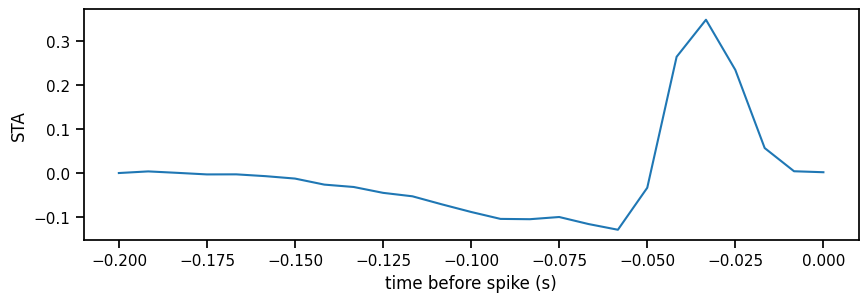

In [8]:
# Compute the spike triggered average (you can do this in one line)
# what size do you think it should be?
sta = (design_mat.T @ spike_counts) / len(spike_times)

### Plot it
sta_times = np.arange(-nlags + 1, 1) * dt_stim  # time bins for STA (in seconds)
plt.figure(figsize=(10, 3))
plt.plot(sta_times, sta)
# plt.scatter(sta_times, sta, marker='o', color='r', s=20)
plt.xlabel("time before spike (s)")
plt.ylabel("STA")

# If you're still using cell #1, this should look like a biphasic filter
# with a negative lobe just prior to the spike time.

## 4. Add an offset term

So far, we have built a design matrix that will allow us to learn a weight
corresponding to the stimulus at each lagged time point leading up to our
neuron's response. However, we also need to include an offset term that allows
our model to learn a fit that doesn't necessarily go through the origin.
(Remember $y = mx + b$ from high school? What happens if we reduce this model
to only be $y = mx$? What solutions are we limited to?)

To allow our model to learn an offset term, add a column of ones to the
beginning of the design matrix using `np.hstack`.

Text(0, 0.5, 'STA')

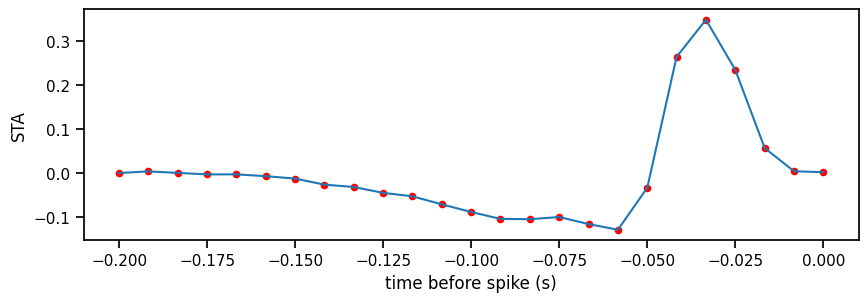

In [9]:
### INSERT CODE HERE
design_with_bias = np.column_stack([np.ones(design_mat.shape[0]), design_mat])
sta_w_bias = (design_with_bias.T @ spike_counts) / len(spike_times)


plt.figure(figsize=(10, 3))
plt.plot(sta_times, sta_w_bias[1:])
plt.scatter(sta_times, sta, marker='o', color='r', s=20)
plt.xlabel("time before spike (s)")
plt.ylabel("STA")

## 5. Define the log-likelihood for the Poisson GLM model

For a given (stimulus, spike count) sample $(x_i,y_i)$, we want to define our
model as $ y_i \sim ~ \text{Poission}(\lambda)$, where $\lambda = \text{exp}(x_i\theta)$.

Our goal is to learn the value of $\theta$ for which the likelihood of seeing
our observed data $P(y_i | x_i, \theta)$ is maximized. The likelihood for a
Poission distribution is proportional to $\lambda^y\text{exp}(-\lambda)$. Substituting
in our equation for $\lambda$, our optimization problem for a single sample
becomes:
$\theta_{\text{opt}} = \text{argmax}_{\theta} [\text{exp}(x_i\theta)^{y_i}\text{exp}(\text{exp}(x_i\theta))]$.

Since we want the $\theta$ that best fits our entire set of samples, we want to
take the product of the above likelihood across all $i$, or equivalently the
sum of the log-likelihoods:
$\theta_{\text{opt}} = \text{argmax}_{\theta} [\sum_{i} [y_ix_i\theta - \text{exp}(x_i\theta)]]$.

Implement this computation of the log-likelihood below for a given value
of $\theta$. Note that in the next step, we will be using an optimization method
that minimizes a likelihood function (as opposed to maximizing), so we will
actually want to take negative of the value above as our return value.

Be careful to use the proper operators for matrix vs element-wise multiplication.

In [10]:
spike_counts.shape

(144051,)

In [11]:
spike_counts * (design_mat @ sta)

array([-0., -0., -0., ..., -0., -0., -0.], shape=(144051,))

In [12]:
def neg_log_likelihood(theta, X, Y):
    theta = theta.reshape(-1, 1)
    x_dot_theta = (X @ theta).reshape(-1)
    LL = (Y * x_dot_theta - np.exp(x_dot_theta)).sum()
    return -LL

## 6. Find the optimal $\theta$

Now that we have defined our negative log likelihood function, we want to find
the value of $\theta$ that minimizes this function given the data we observe.
Use the function `minimize` from `scipy.optimize` to find the optimal value
of $\theta$.

In [25]:
theta_init = np.random.randn(26)
theta_opt = minimize(neg_log_likelihood, theta_init, (design_with_bias, spike_counts), method='L-BFGS-B')['x']

[-1.93912449  0.00761044  0.01775635  0.00391515 -0.01368025 -0.01986823
 -0.03867393 -0.05218167 -0.10044593 -0.12434752 -0.19540878 -0.23327446
 -0.32255694 -0.40001303 -0.46124432 -0.46235437 -0.43928838 -0.52066701
 -0.58597536 -0.15804368  1.28497999  1.91338791  1.10402062  0.23188763
  0.0033111  -0.01119215]


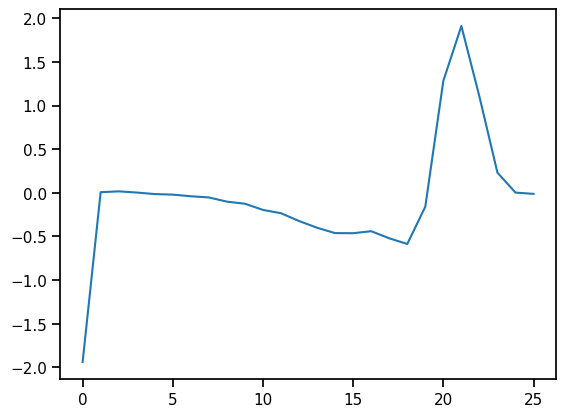

In [26]:
plt.plot(theta_opt)

## 7. Predict with learned values of $\theta$

Use the optimal value of $\theta$ found above to predict from the design matrix
what spike counts we should observe.

In [21]:
spike_counts_pred = design_with_bias @ theta_opt

Plot these predictions over the observed data that you plotted in step 2.

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/folders/48/jp5t51cd1b77fn50_y71wwlw0000gn/T/ipykernel_94919/1146665508.py:5: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(np.linspace(0, 1, 120), np.exp(spike_counts_pred[:nframes_to_plot]), c='red', label='$\exp{k * x}$')


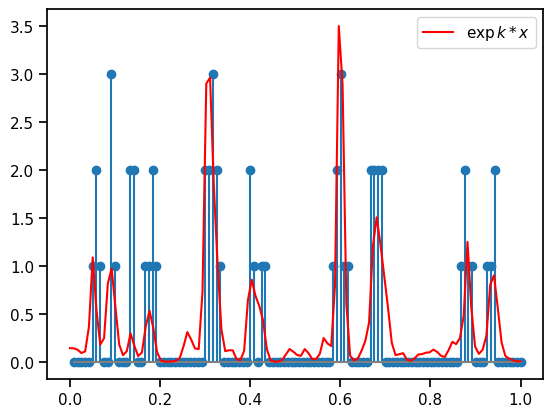

In [33]:
# plot the spike counts over the first 1s of the trial
### INSERT CODE HERE

plt.stem(stim_times[:nframes_to_plot], spike_counts[:nframes_to_plot], basefmt="gray")
plt.plot(np.linspace(0, 1, 120), np.exp(spike_counts_pred[:nframes_to_plot]), c='red', label='$\exp{k * x}$')
plt.legend()

Plot the optimal value of $\theta$ that you found over the STA that you
plotted in step 3. Note that $\theta$ is a vector - make sure to only plot
the entries in this vector that make sense to compare to the STA.
Additionally, since we are comparing two distinct quantities, normalize both
$\theta_{\text{opt}}$ and the STA so that we can just compare their shapes.

What do you observe? Does this comparison make sense?

In [37]:
sta_w_bias[1:].sum()

np.float64(-0.012587580574412277)

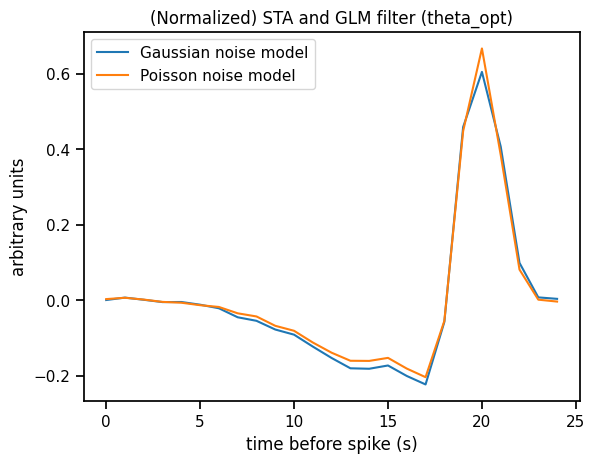

In [40]:
# sta_times = ### INSERT CODE HERE

plt.plot(sta_w_bias[1:] / np.linalg.norm(sta_w_bias[1:]), label='Gaussian noise model')
plt.plot(theta_opt[1:] / np.linalg.norm(theta_opt[1:]), label='Poisson noise model')

plt.xlabel("time before spike (s)")
plt.ylabel("arbitrary units")
plt.title("(Normalized) STA and GLM filter (theta_opt)")
plt.legend()

## 8. Use statsmodels package instead

While in the previous steps you constructed a log-likelihood function by hand
to optimize with respect to, the package `statsmodels` has built-in model types
for which it will perform this optimization automatically. Review the example
below to see how you can use `statsmodels` to perform the same analysis as
above more succinctly and verify that your results match those from this
implementation.

In [41]:
glm_poisson_exp = sm.GLM(
    endog=spike_counts, exog=design_mat, family=sm.families.Poisson()
)
pGLM_results = glm_poisson_exp.fit(max_iter=100, tol=1e-6, tol_criterion="params")
spike_counts_pred = np.exp(design_mat @ pGLM_results.params)

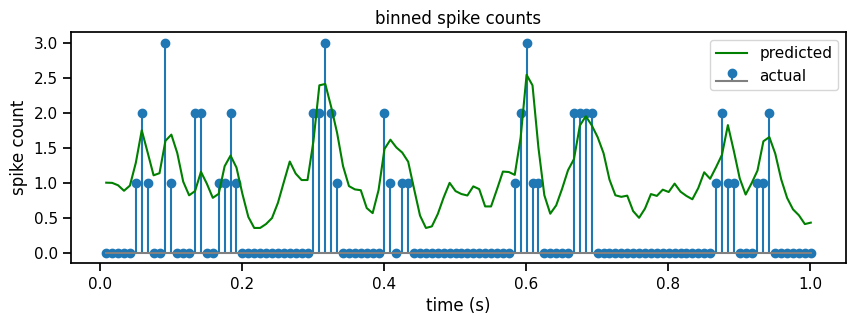

In [42]:
# plot the spike counts over the first 1s of the trial
plt.figure(figsize=(10, 3))
plt.stem(stim_times[:nframes_to_plot], spike_counts[:nframes_to_plot], basefmt="gray")
plt.plot(
    stim_times[:nframes_to_plot], spike_counts_pred[:nframes_to_plot], color="green"
)
plt.title("binned spike counts")
plt.ylabel("spike count")
plt.xlabel("time (s)")
plt.legend(["predicted", "actual"])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (25,) and (24,)

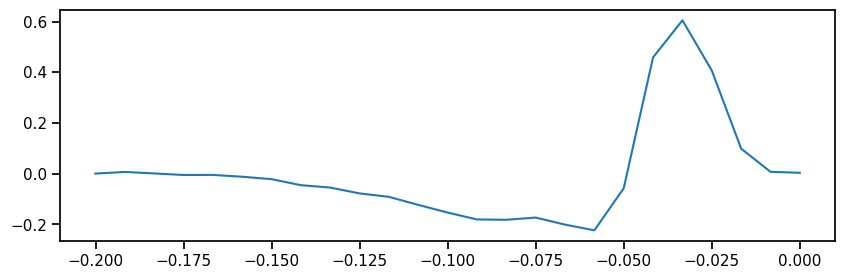

In [43]:
sta_times = np.arange(-nlags + 1, 1) * dt_stim  # time bins for STA (in seconds)
plt.figure(figsize=(10, 3))
plt.plot(sta_times, sta / norm(sta), label="STA")
plt.plot(
    sta_times,
    pGLM_results.params[1:] / norm(pGLM_results.params[1:]),
    label="theta_opt",
)
plt.xlabel("time before spike (s)")
plt.ylabel("arbitrary units")
plt.title("(Normalized) STA and GLM filter (theta_opt)")
plt.legend()